# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель** проекта - построить модель машинного обучения для определения стоимости автомобиля. 

**Задачи** 
 * Загрузить и подготовить данные.
 * Обучить разные модели, подобрать гиперпараметры.
 * Проанализировать скорость работы и качество моделей.

**Описание данных**

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

## Подготовка данных

Импортируем библиотеки и модкли, которые нам понадобятся

In [59]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from catboost import cv, Pool
from lightgbm import LGBMRegressor
import lightgbm as lgb

Считаем датасет

In [2]:
df = pd.read_csv('autos.csv')

Посмотрим на первые 5 строк таблицы

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В каждой строке представлена информация о машине.
Уже на данном этапе можно заметить, что в датафрейме встречаются пропуски, присутствует столбец, в котором в первых пяти строках значение 0, три столбца с датами, которые потом лучше будет растащить на отдельные фичи и названия колонок не очень удобные

Посмотрим общую информацию о таблице

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видим, что у столбцов с датами тип данных object, что не очень удобно

Посмотрим на доли пропусков

In [5]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Пропуски встречаются в пяти столбцах, причём во всех из них данные типа object.

Посмотрим основные количественные характеристики для колическтвенных данных

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Виден ряд аномалий: 
 * нулевая цена - скорее всего выбросы, нужно будет удалить эти данные
 * нулевая сила - скорее всего выбросы, нужно будет удалить эти данные
 * 1000 и 9999 год регистрации - скорее всего выбросы, нужно будет удалить эти данные
 * 0 месяц регистрации - с ним непонятно, что делать, скорее всего, это обозначение для пропуска, поэтому оставим как есть
 * пустой столбец с количеством фотографий, состоящий только из нулей - удалим его

Удалим столбец NumberOfPictures

In [7]:
df.drop('NumberOfPictures', axis=1, inplace=True)

Проверим, что он удалился

In [8]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

Для удобства переименуем столбцы

In [9]:
df = df.rename (columns= {'DateCrawled' : 'download_date', 'Price' : 'price', 'VehicleType' : 'vehicle_type',
                          'RegistrationYear' : 'registration_year', 'Gearbox' : 'gearbox', 'Power' : 'power', 
                          'Model' : 'model', 'Kilometer' : 'kilometer', 'RegistrationMonth' : 'registration_month',
                          'FuelType' : 'fuel_type', 'Brand' : 'brand', 'NotRepaired' : 'not_repaired', 'DateCreated' : 'date_created',
                          'PostalCode' : 'postal_code', 'LastSeen' : 'last_seen'})

Убедимся, что названия столбцов изменились

In [10]:
df

,download_date,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439,2016-04-07 07:15:26


Реализуем функцию для добавления новых фичей из даты

In [11]:
def add_date(df, date_str):
    '''
    Функция принимает на вход датафрейм и записанное строкой названия столбца, из которого вытаскиваются фичи.
    Для начала функция приводит дату к типу datetime, а потом в датафрейм добавляются столбцы с годом, месяцем, днём,
    часом, минутой и секундой с соотвествующими названиями.
    Возвращает функция получившийся в итоге датафрейм
    '''
    df[date_str] = pd.to_datetime(df[date_str], format="%Y-%m-%d %H:%M:%S")
    df[date_str+'_year'] = pd.DatetimeIndex(df[date_str]).year 
    df[date_str+'_month'] = pd.DatetimeIndex(df[date_str]).month
    df[date_str+'_day'] = pd.DatetimeIndex(df[date_str]).day
    df[date_str+'_hour'] = pd.DatetimeIndex(df[date_str]).hour 
    df[date_str+'_minute'] = pd.DatetimeIndex(df[date_str]).minute 
    df[date_str+'_second'] = pd.DatetimeIndex(df[date_str]).second 
    return df

Применим эту функцию к нашему датафрейму и столбцам download_date, date_created и last_seen

In [12]:
df = add_date(df, 'download_date')

In [13]:
df = add_date(df, 'date_created')

In [14]:
df = add_date(df, 'last_seen')

Убедимся, что новые столбцы появились

In [15]:
df

,download_date,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,...,date_created_day,date_created_hour,date_created_minute,date_created_second,last_seen_year,last_seen_month,last_seen_day,last_seen_hour,last_seen_minute,last_seen_second
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,...,24,0,0,0,2016,4,7,3,16,57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,...,24,0,0,0,2016,4,7,1,46,50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,14,0,0,0,2016,4,5,12,47,46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,17,0,0,0,2016,3,17,17,40,17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,31,0,0,0,2016,4,6,10,17,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,...,21,0,0,0,2016,3,21,10,42,49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,...,14,0,0,0,2016,4,6,0,46,52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,...,5,0,0,0,2016,3,11,18,17,12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,...,19,0,0,0,2016,4,7,7,15,26


Посмотрим общую информацию о таблице

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   download_date         354369 non-null  datetime64[ns]
 1   price                 354369 non-null  int64         
 2   vehicle_type          316879 non-null  object        
 3   registration_year     354369 non-null  int64         
 4   gearbox               334536 non-null  object        
 5   power                 354369 non-null  int64         
 6   model                 334664 non-null  object        
 7   kilometer             354369 non-null  int64         
 8   registration_month    354369 non-null  int64         
 9   fuel_type             321474 non-null  object        
 10  brand                 354369 non-null  object        
 11  not_repaired          283215 non-null  object        
 12  date_created          354369 non-null  datetime64[ns]
 13 

И основные числовые характеристики

In [17]:
df.describe()

,price,registration_year,power,kilometer,registration_month,postal_code,download_date_year,download_date_month,download_date_day,download_date_hour,...,date_created_day,date_created_hour,date_created_minute,date_created_second,last_seen_year,last_seen_month,last_seen_day,last_seen_hour,last_seen_minute,last_seen_second
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000,354369.000000,354369.000000,...,354369.000000,354369.0,354369.0,354369.0,354369.0,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,50508.689087,2016.0,3.162387,15.852783,14.909665,...,15.859689,0.0,0.0,0.0,2016.0,3.564987,11.963456,11.813835,33.267868,30.073754
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,25783.096248,0.0,0.368806,9.116311,5.422938,...,9.123133,0.0,0.0,0.0,0.0,0.495759,8.886562,6.516410,14.693983,16.949339
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000,2016.0,3.000000,1.000000,0.000000,...,1.000000,0.0,0.0,0.0,2016.0,3.000000,1.000000,0.000000,0.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000,2016.0,3.000000,8.000000,12.000000,...,8.000000,0.0,0.0,0.0,2016.0,3.000000,6.000000,7.000000,17.000000,16.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000,2016.0,3.000000,16.000000,16.000000,...,16.000000,0.0,0.0,0.0,2016.0,4.000000,7.000000,12.000000,44.000000,30.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000,2016.0,3.000000,24.000000,19.000000,...,24.000000,0.0,0.0,0.0,2016.0,4.000000,19.000000,17.000000,46.000000,45.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000,2016.0,4.000000,31.000000,23.000000,...,31.000000,0.0,0.0,0.0,2016.0,4.000000,31.000000,23.000000,59.000000,59.000000


Столбцы с датами нам теперь не нужны. А кроме того, удалим появившиеся нулевые столбцы

In [18]:
df.drop(['download_date', 'date_created', 'last_seen', 'download_date_year', 'date_created_hour', 'date_created_minute', 'date_created_second', 'last_seen_year'], axis=1, inplace=True)

Убедимся, что ненужных столбцов не осталось

In [19]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,...,download_date_minute,download_date_second,date_created_year,date_created_month,date_created_day,last_seen_month,last_seen_day,last_seen_hour,last_seen_minute,last_seen_second
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,...,52,17,2016,3,24,4,7,3,16,57
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,...,58,45,2016,3,24,4,7,1,46,50
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,...,52,21,2016,3,14,4,5,12,47,46
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,54,4,2016,3,17,3,17,17,40,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,25,20,2016,3,31,4,6,10,17,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,...,50,58,2016,3,21,3,21,10,42,49
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,...,48,27,2016,3,14,4,6,0,46,52
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,...,56,21,2016,3,5,3,11,18,17,12
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,...,57,12,2016,3,19,4,7,7,15,26


## Пропуски

Перейдём к заполнению пропусков. Посмотрим ещё раз, где они встречаются

In [20]:
df.isna().mean()

price                   0.000000
vehicle_type            0.105794
registration_year       0.000000
gearbox                 0.055967
power                   0.000000
model                   0.055606
kilometer               0.000000
registration_month      0.000000
fuel_type               0.092827
brand                   0.000000
not_repaired            0.200791
postal_code             0.000000
download_date_month     0.000000
download_date_day       0.000000
download_date_hour      0.000000
download_date_minute    0.000000
download_date_second    0.000000
date_created_year       0.000000
date_created_month      0.000000
date_created_day        0.000000
last_seen_month         0.000000
last_seen_day           0.000000
last_seen_hour          0.000000
last_seen_minute        0.000000
last_seen_second        0.000000
dtype: float64

Поскольку все пропуски в строковых данных, заполним их новой строкой, которая не встречается, например, 'no_info'

In [21]:
# список столбцов с пропусками
list_with_nan = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']

In [22]:
# создание датафрейма без пропусков
df_without_nan = df.copy()

In [23]:
# заполнение датафрейма
df_without_nan[list_with_nan] = df_without_nan[list_with_nan].fillna('no_info')

## Выбросы

Составим списки фичей - отдельно категориальных, отдельно количественных

In [24]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
features = ['vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'postal_code', 'download_date_month',
       'download_date_day', 'download_date_hour', 'download_date_minute',
       'download_date_second', 'date_created_year', 'date_created_month',
       'date_created_day', 'last_seen_month', 'last_seen_day',
       'last_seen_hour', 'last_seen_minute', 'last_seen_second']
int_features = [_ for _ in features if _ not in cat_features]

Оценим выбросы отдельно по нескольким столбцам с помощью построения боксплотов

### registration_year

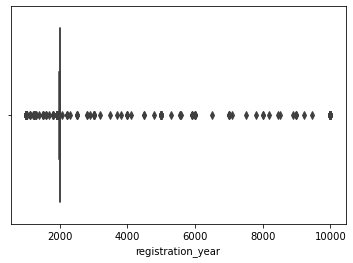

In [25]:
ax = sns.boxplot(x="registration_year", data=df)

Видим, что очень много выбросов со слишком большими значениями. Ограничим сверху 2018 годом

In [26]:
df_no_anomaly = df[df['registration_year'] <= 2018]

Оценим выбросы снизу

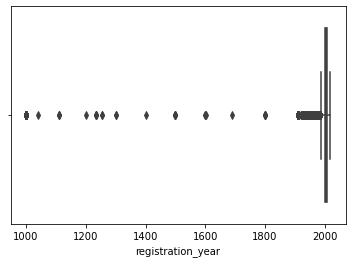

In [27]:
ax = sns.boxplot(x="registration_year", data=df_no_anomaly)

Ограничим 1970 годом

In [28]:
df_no_anomaly = df_no_anomaly[df_no_anomaly['registration_year'] >= 1970]

Изучим результат

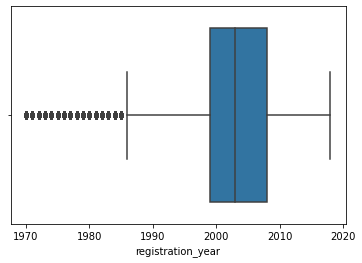

In [29]:
ax = sns.boxplot(x="registration_year", data=df_no_anomaly)

### Price

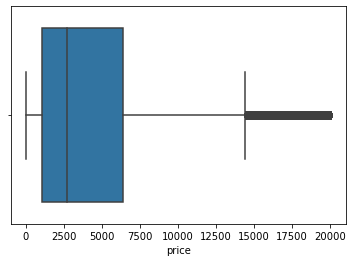

In [30]:
ax = sns.boxplot(x="price", data=df_no_anomaly)

Нулевая цена кажется подозрительной. Возьмём ненулевое значение для оценки. А выбросы сверху выглядят правдоподобно - их не будем трогать

In [31]:
df_no_anomaly = df_no_anomaly[df_no_anomaly['price'] >= 20]

## power

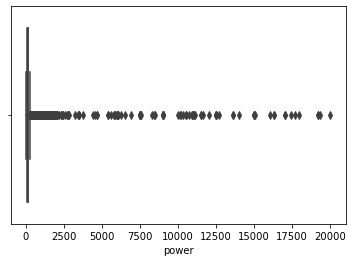

In [32]:
ax = sns.boxplot(x="power", data=df_no_anomaly)

Аналогично ограничим снизу силу

In [33]:
df_no_anomaly = df_no_anomaly[df_no_anomaly['power'] >= 20]

Итак, датафрейм с пропусками, но без аномалий имеет следующий вид

In [34]:
df_no_anomaly

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,...,download_date_minute,download_date_second,date_created_year,date_created_month,date_created_day,last_seen_month,last_seen_day,last_seen_hour,last_seen_minute,last_seen_second
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,...,58,45,2016,3,24,4,7,1,46,50
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,...,52,21,2016,3,14,4,5,12,47,46
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,54,4,2016,3,17,3,17,17,40,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,25,20,2016,3,31,4,6,10,17,21
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,...,36,23,2016,4,4,4,6,19,17,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,...,37,43,2016,3,9,3,13,1,44,13
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,...,53,49,2016,3,19,3,19,20,44,43
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,...,56,21,2016,3,5,3,11,18,17,12
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,...,57,12,2016,3,19,4,7,7,15,26


Проделаем аналогичную работу для датафрейма без пропусков

### registration_year

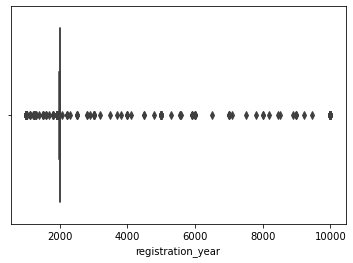

In [35]:
ax = sns.boxplot(x="registration_year", data=df_without_nan)

In [36]:
df_without_nan_no_anomaly = df_without_nan[df_without_nan['registration_year'] <= 2018]

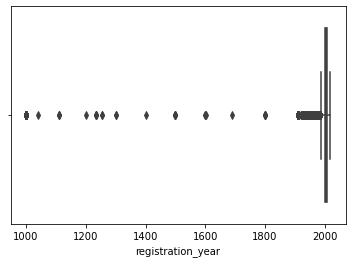

In [37]:
ax = sns.boxplot(x="registration_year", data=df_without_nan_no_anomaly)

In [38]:
df_without_nan_no_anomaly = df_without_nan_no_anomaly[df_without_nan_no_anomaly['registration_year'] >= 1970]

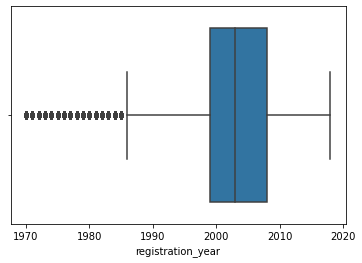

In [39]:
ax = sns.boxplot(x="registration_year", data=df_without_nan_no_anomaly)

### Price

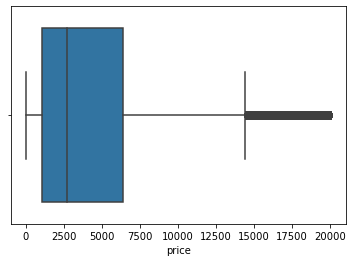

In [40]:
ax = sns.boxplot(x="price", data=df_without_nan_no_anomaly)

In [41]:
df_without_nan_no_anomaly = df_without_nan_no_anomaly[df_without_nan_no_anomaly['price'] >= 20]

## power

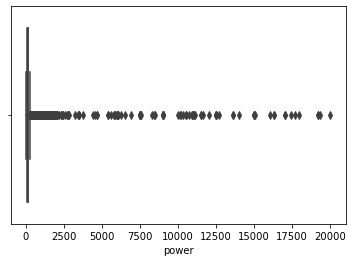

In [42]:
ax = sns.boxplot(x="power", data=df_without_nan_no_anomaly)

In [43]:
df_without_nan_no_anomaly = df_without_nan_no_anomaly[df_without_nan_no_anomaly['power'] >= 20]

Датафрейм без пропусков и без аномалий выглядит следующим образом:

In [44]:
df_without_nan_no_anomaly

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,...,download_date_minute,download_date_second,date_created_year,date_created_month,date_created_day,last_seen_month,last_seen_day,last_seen_hour,last_seen_minute,last_seen_second
1,18300,coupe,2011,manual,190,no_info,125000,5,gasoline,audi,...,58,45,2016,3,24,4,7,1,46,50
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,...,52,21,2016,3,14,4,5,12,47,46
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,54,4,2016,3,17,3,17,17,40,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,25,20,2016,3,31,4,6,10,17,21
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,...,36,23,2016,4,4,4,6,19,17,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,no_info,2016,auto,150,159,150000,12,no_info,alfa_romeo,...,37,43,2016,3,9,3,13,1,44,13
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,...,53,49,2016,3,19,3,19,20,44,43
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,...,56,21,2016,3,5,3,11,18,17,12
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,...,57,12,2016,3,19,4,7,7,15,26


Убедимся, что у нас нет сильно скоррелированных признаков

In [45]:
corr_matrix = df.corr()

In [46]:
corr_matrix

,price,registration_year,power,kilometer,registration_month,postal_code,download_date_month,download_date_day,download_date_hour,download_date_minute,download_date_second,date_created_year,date_created_month,date_created_day,last_seen_month,last_seen_day,last_seen_hour,last_seen_minute,last_seen_second
price,1.000000,0.026916,0.158872,-0.333199,0.110581,0.076055,0.016530,-0.006756,0.017560,-0.008729,-0.000382,-0.005551,0.014367,-0.005795,0.149443,-0.103391,-0.020093,-0.033912,0.002296
registration_year,0.026916,1.000000,-0.000828,-0.053447,-0.011619,-0.003459,-0.000845,0.001234,-0.001617,-0.002793,-0.001559,0.000056,-0.000728,0.001110,-0.000630,0.000870,-0.000314,0.002297,0.002204
power,0.158872,-0.000828,1.000000,0.024002,0.043380,0.021665,0.003658,-0.001946,-0.000617,-0.001717,0.002466,0.000057,0.003290,-0.001812,0.020849,-0.013753,-0.003176,-0.006561,0.000803
kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,-0.007698,-0.002671,0.001316,-0.011518,-0.001677,0.002740,0.004664,-0.001820,0.000627,-0.062445,0.041906,0.010456,0.013543,-0.001359
registration_month,0.110581,-0.011619,0.043380,0.009571,1.000000,0.013995,-0.002319,-0.001679,0.012123,-0.004741,0.001787,0.003290,-0.002460,-0.001923,0.001433,-0.003657,0.004620,0.002001,0.001284
postal_code,0.076055,-0.003459,0.021665,-0.007698,0.013995,1.000000,0.010526,0.001348,0.016590,-0.033107,-0.003884,0.000591,0.010182,0.001488,0.043501,-0.029997,0.002221,-0.017050,-0.000023
download_date_month,0.016530,-0.000845,0.003658,-0.002671,-0.002319,0.010526,1.000000,-0.627917,-0.032011,-0.024951,0.001639,0.002017,0.973855,-0.619143,0.386354,-0.333666,0.101165,0.000972,-0.017712
download_date_day,-0.006756,0.001234,-0.001946,0.001316,-0.001679,0.001348,-0.627917,1.000000,0.008740,0.040350,-0.000932,0.003560,-0.608346,0.991606,-0.018897,0.218404,-0.071310,0.010823,0.023318
download_date_hour,0.017560,-0.001617,-0.000617,-0.011518,0.012123,0.016590,-0.032011,0.008740,1.000000,0.041695,0.004999,0.000205,-0.023983,0.008118,0.008979,-0.011609,0.107129,0.001122,-0.001922
download_date_minute,-0.008729,-0.002793,-0.001717,-0.001677,-0.004741,-0.033107,-0.024951,0.040350,0.041695,1.000000,0.019968,0.000637,-0.025178,0.041697,0.000323,0.010232,-0.016681,0.071593,0.003262


Видим сильную корреляцию между столбцами date_created_day и download_date_day, а также date_created_month и download_date_month. Но поскольку с целевым признаком сильной корреляции ни у чего нет, оставим эти слолбцы

## Удаление лишних столбцов и дубликатов

### df

In [47]:
df.drop(['download_date_month',
       'download_date_day', 'download_date_hour', 'download_date_minute',
       'download_date_second', 'date_created_year', 'date_created_month',
       'date_created_day', 'last_seen_month', 'last_seen_day',
       'last_seen_hour', 'last_seen_minute', 'last_seen_second', 'postal_code'], axis=1, inplace=True)

In [48]:
# подсчёт явных дубликатов
df.duplicated().sum()

27543

In [49]:
# удаление явных дубликатов (с удалением старых индексов и формированием новых)
df = df.drop_duplicates().reset_index(drop=True)

### df_no_anomaly

In [50]:
df_no_anomaly.drop(['download_date_month',
       'download_date_day', 'download_date_hour', 'download_date_minute',
       'download_date_second', 'date_created_year', 'date_created_month',
       'date_created_day', 'last_seen_month', 'last_seen_day',
       'last_seen_hour', 'last_seen_minute', 'last_seen_second', 'postal_code'], axis=1, inplace=True)

In [51]:
# подсчёт явных дубликатов
df_no_anomaly.duplicated().sum()

23596

In [52]:
df_no_anomaly = df_no_anomaly.drop_duplicates().reset_index(drop=True)

### df_without_nan

In [53]:
df_without_nan.drop(['download_date_month',
       'download_date_day', 'download_date_hour', 'download_date_minute',
       'download_date_second', 'date_created_year', 'date_created_month',
       'date_created_day', 'last_seen_month', 'last_seen_day',
       'last_seen_hour', 'last_seen_minute', 'last_seen_second', 'postal_code'], axis=1, inplace=True)

In [54]:
# подсчёт явных дубликатов
df_without_nan.duplicated().sum()

27543

In [55]:
df_without_nan = df_without_nan.drop_duplicates().reset_index(drop=True)

### df_without_nan_no_anomaly

In [56]:
df_without_nan_no_anomaly.drop(['download_date_month',
       'download_date_day', 'download_date_hour', 'download_date_minute',
       'download_date_second', 'date_created_year', 'date_created_month',
       'date_created_day', 'last_seen_month', 'last_seen_day',
       'last_seen_hour', 'last_seen_minute', 'last_seen_second', 'postal_code'], axis=1, inplace=True)

In [57]:
# подсчёт явных дубликатов
df_without_nan_no_anomaly.duplicated().sum()

23596

In [58]:
df_without_nan_no_anomaly = df_without_nan_no_anomaly.drop_duplicates().reset_index(drop=True)

In [61]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
features = ['vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired']
int_features = [_ for _ in features if _ not in cat_features]

## Кодирование

Закодируем наши категориальные признаки. Для этого  воспользуемся техникой OrdinalEncoding

In [62]:
ord_enc = OrdinalEncoder()

In [63]:
df_ohe = df.copy()
df_ohe[cat_features] = ord_enc.fit_transform(df[cat_features])

In [65]:
df_no_anomaly_ohe = df_no_anomaly.copy()
df_no_anomaly_ohe[cat_features] = ord_enc.fit_transform(df_no_anomaly[cat_features])

In [66]:
df_without_nan_ohe = df_without_nan.copy()
df_without_nan_ohe[cat_features] = ord_enc.fit_transform(df_without_nan[cat_features])

In [67]:
df_without_nan_no_anomaly_ohe = df_without_nan_no_anomaly.copy()
df_without_nan_no_anomaly_ohe[cat_features] = ord_enc.fit_transform(df_without_nan_no_anomaly[cat_features])

Итак, на данном этапе у нас есть 6 значимых датафреймов для проверки разных моделей - df_without_nan, df_without_nan_no_anomaly, df_without_nan_ohe, df_without_nan_no_anomaly_ohe, df_ohe, df_no_anomaly_ohe. Каждый из них необходимо разделить на тестовую и обучающую выборки

## Деление на выборки

Реализуем функцию деления на выборки

In [69]:
def split_function(df):
    '''
    Функция принимает на вход датафрейм. 
    Выделяет в переменную target столбец с ценой, а в переменную features все остальные столбцы.
    При помощи функции train_test_split делит данные на выборки и возвращает 
    features_train, features_valid, features_test, target_train, target_valid, target_test    '''
    target = df['price']
    features = df.drop('price', axis=1)
    features_train, features_other, target_train, target_other = train_test_split(features, target, test_size=0.4, random_state=42)
    features_test, features_valid, target_test, target_valid = train_test_split(features_other, target_other, test_size=0.5, random_state=42)
    return features_train, features_valid, features_test, target_train, target_valid, target_test

Применим получившуюся функцию для наших датафреймов

In [70]:
features_train_without_nan, features_valid_without_nan, features_test_without_nan,\
target_train_without_nan, target_valid_without_nan, target_test_without_nan = split_function(df_without_nan)

In [71]:
features_train_without_nan_no_anomaly, features_valid_without_nan_no_anomaly, features_test_without_nan_no_anomaly,\
target_train_without_nan_no_anomaly, target_valid_without_nan_no_anomaly, target_test_without_nan_no_anomaly \
= split_function(df_without_nan_no_anomaly)

In [72]:
features_train_without_nan_ohe, features_valid_without_nan_ohe, features_test_without_nan_ohe, \
target_train_without_nan_ohe, target_valid_without_nan_ohe, target_test_without_nan_ohe = split_function(df_without_nan_ohe)

In [74]:
features_train_without_nan_no_anomaly_ohe, features_valid_without_nan_no_anomaly_ohe, \
features_test_without_nan_no_anomaly_ohe, target_train_without_nan_no_anomaly_ohe, \
target_valid_without_nan_no_anomaly_ohe, target_test_without_nan_no_anomaly_ohe = split_function(df_without_nan_no_anomaly_ohe)

In [76]:
features_train_ohe, features_valid_ohe, features_test_ohe,\
target_train_ohe, target_valid_ohe, target_test_ohe = split_function(df_ohe)

In [77]:
features_train_no_anomaly_ohe, features_valid_no_anomaly_ohe, features_test_no_anomaly_ohe, \
target_train_no_anomaly_ohe, target_valid_no_anomaly_ohe, target_test_no_anomaly_ohe = split_function(df_no_anomaly_ohe)

<div style="border:solid blue 2px; padding: 20px">

**Выводы**

На данном этапе 
 * данные были предобработаны
   * удалены лишние столбцы
   * в отдельные датасеты были сохранены данные с пропусками, аномалиями и без
   * часть данных была закодирована
 * данные были поделены на выборки в каждом из получившихся датасетов

## Обучение моделей

### Дерево решений

Реализуем функцию для поиска параметров дерева решений. Будем перебирать глубину дерева от 1 до 14

In [78]:
def decision_tree(features_train, features_valid, target_train, target_valid):
    best_tree_model = None # переменная для наилучшей модели
    best_tree_result = 10000000 # rmse наилучшей модели
    for depth in range(1, 15):
        model_tree = DecisionTreeRegressor(random_state=42, max_depth=depth) 
        model_tree.fit(features_train, target_train) # обучение модели на тренировочной выборке
        predicted_valid = model_tree.predict(features_valid) 
        
        result_tree = (mean_squared_error(target_valid, predicted_valid)) ** 0.5
        # условие проверки лучшего результата
        if result_tree < best_tree_result:
            best_tree_model = model_tree 
            best_tree_result = result_tree 
    print()
    print("rmse наилучшей модели на валидационной выборке:", best_tree_result)
    print(best_tree_model)

Проверим эту функцию для наших датасетов, подходящих для дерева

In [79]:
%%time
decision_tree(features_train_without_nan_ohe, features_valid_without_nan_ohe, \
target_train_without_nan_ohe, target_valid_without_nan_ohe)


rmse наилучшей модели на валидационной выборке: 2095.2047367002137
DecisionTreeRegressor(max_depth=11, random_state=42)
CPU times: total: 4.94 s
Wall time: 5.08 s


In [80]:
%%time
decision_tree(features_train_without_nan_no_anomaly_ohe, features_valid_without_nan_no_anomaly_ohe, \
target_train_without_nan_no_anomaly_ohe, target_valid_without_nan_no_anomaly_ohe)


rmse наилучшей модели на валидационной выборке: 1925.2225013175057
DecisionTreeRegressor(max_depth=13, random_state=42)
CPU times: total: 4 s
Wall time: 4.25 s


Наилучший результат (rmse = 1925) показывает дерево с 13 деревьями для закодированного датасета без пропусков и аномалий. 

### LightGBM 

Зафиксируем RANDOM_STATE

In [81]:
RANDOM_STATE = 42

Реализуем функцию для проверки параметров для модели lightGBM. Посмотрим, как в зависимости от изменения параметров будет меняться качетсво модели

In [82]:
def lightgbm_model(params, features_train, features_valid, target_train, target_valid):
    lgbm_model = LGBMRegressor(**params)
    lgbm_model.fit(features_train, target_train)
    predictions_lgbm = lgbm_model.predict(features_valid)
    return mean_squared_error(target_valid, predictions_lgbm) ** 0.5


Для начала попробуем поизменять learning_rate, а потом verbose

In [83]:
params4 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.4,
    'verbose': 0
}


In [84]:
params6 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.5,
    'verbose': 0
}


In [85]:
params7 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.6,
    'verbose': 0
}


In [86]:
params8 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.5,
    'verbose': 100
}


Начнём проверку

In [87]:
%%time
lightgbm_model(params4, features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

1794.4841455411217

In [88]:
%%time
lightgbm_model(params6, features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: total: 2.78 s
Wall time: 826 ms


1791.9505544380818

In [89]:
%%time
lightgbm_model(params7, features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

1797.1263663612312

Видим, что при 'learning_rate' = 0.5 качество лучше, чем при двух соседних, значит, в этой точке находится локальный минимум

Проверим, как меняется качество при увеличении verbose

In [90]:
%%time
lightgbm_model(params8, features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.726553
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.176444
[LightGBM] [Debug] init for col-wise cost 0.003266 seconds, init for row-wise cost 0.006436 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 196095, number of used features: 10
[LightGBM] [Info] Start training from score 4410.290660
[LightGBM] [Debug] Trained

1791.9505544380818

Видим, что качество не поменялось. Оставим параметры 'learning_rate' = 0.5, 'verbose' = 0. И проверим на разных, подходящих для LightGBM датасетах

In [91]:
%%time
lightgbm_model(params6, features_train_no_anomaly_ohe, features_valid_no_anomaly_ohe, \
               target_train_no_anomaly_ohe, target_valid_no_anomaly_ohe)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: total: 2.41 s
Wall time: 753 ms


1650.3717894709705

In [92]:
%%time
lightgbm_model(params6, features_train_without_nan_no_anomaly_ohe, features_valid_without_nan_no_anomaly_ohe, \
               target_train_without_nan_no_anomaly_ohe, target_valid_without_nan_no_anomaly_ohe)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: total: 2.41 s
Wall time: 760 ms


1652.6982153911792

Итак, LightGBM наилучший результат (rmse = 1650) показывает модель с параметрами  'learning_rate' = 0.5, 'verbose' = 0 на закодированным датасете без аномалий

### Catboost

Категориальные признаки представлены ниже:

In [93]:
cat_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

Проверим модель Catboost. Подберём параметр iterations

In [94]:
for iteration in range(120, 201, 25):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, verbose=10, cat_features=cat_features)
    cat_cv = cross_val_score(cat_model, features_train_without_nan, target_train_without_nan, cv=2)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.473644
0:	learn: 3201.6501807	total: 270ms	remaining: 32.2s
10:	learn: 1860.2673654	total: 1.04s	remaining: 10.3s
20:	learn: 1755.7270080	total: 1.78s	remaining: 8.39s
30:	learn: 1692.8389566	total: 2.52s	remaining: 7.25s
40:	learn: 1648.6445955	total: 3.25s	remaining: 6.25s
50:	learn: 1609.6252428	total: 3.97s	remaining: 5.38s
60:	learn: 1575.1110042	total: 4.68s	remaining: 4.53s
70:	learn: 1551.2299119	total: 5.4s	remaining: 3.73s
80:	learn: 1527.9123043	total: 6.17s	remaining: 2.97s
90:	learn: 1502.6906693	total: 6.88s	remaining: 2.19s
100:	learn: 1480.0405622	total: 7.61s	remaining: 1.43s
110:	learn: 1462.9824529	total: 8.33s	remaining: 675ms
119:	learn: 1441.9922493	total: 8.98s	remaining: 0us
Learning rate set to 0.473645
0:	learn: 3228.6156111	total: 80.9ms	remaining: 9.63s
10:	learn: 1903.2043098	total: 824ms	remaining: 8.17s
20:	learn: 1795.4899803	total: 1.56s	remaining: 7.34s
30:	learn: 1735.7496580	total: 2.28s	remaining: 6.56s
40:	learn: 1683.0485977

Мы видим, что чем больше iterations в данном диапозоне, тем лучше качество

 Подберём параметр depth

In [95]:
for depth in range(6, 12, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=200, depth=depth, verbose=10, cat_features=cat_features)
    cat_cv = cross_val_score(cat_model, features_train_without_nan, target_train_without_nan, cv=2)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.312672
0:	learn: 3690.8801244	total: 103ms	remaining: 20.6s
10:	learn: 2080.3454802	total: 1.13s	remaining: 19.3s
20:	learn: 1969.1634105	total: 1.96s	remaining: 16.7s
30:	learn: 1914.7815853	total: 2.77s	remaining: 15.1s
40:	learn: 1878.0160167	total: 3.58s	remaining: 13.9s
50:	learn: 1846.6713902	total: 4.53s	remaining: 13.2s
60:	learn: 1829.9799854	total: 5.41s	remaining: 12.3s
70:	learn: 1814.8939446	total: 6.27s	remaining: 11.4s
80:	learn: 1801.6292815	total: 7.07s	remaining: 10.4s
90:	learn: 1787.3588661	total: 7.92s	remaining: 9.49s
100:	learn: 1775.2651099	total: 8.83s	remaining: 8.66s
110:	learn: 1766.5826401	total: 9.71s	remaining: 7.79s
120:	learn: 1759.2211879	total: 10.8s	remaining: 7.06s
130:	learn: 1748.9375928	total: 11.7s	remaining: 6.17s
140:	learn: 1741.0362053	total: 12.7s	remaining: 5.33s
150:	learn: 1736.1564258	total: 13.6s	remaining: 4.42s
160:	learn: 1729.9450716	total: 14.5s	remaining: 3.51s
170:	learn: 1721.1925824	total: 15.4s	remainin

В качестве параметра depth возьмём 8. 

Реализуем функцию обучения и проверки нашей модели.

In [96]:
def cat_model(features_train, target_train, features_valid, target_valid):
    cat_best_model = CatBoostRegressor(loss_function="RMSE", iterations=200, depth=8, verbose=10)
    cat_best_model.fit(features_train, target_train, cat_features=cat_features)
    predicted_cat = pd.Series(cat_best_model.predict(features_valid))
    return mean_squared_error(target_valid, predicted_cat) ** 0.5

Проверим её на подходящих для CatBoost датасетах

In [97]:
cat_model(features_train_without_nan, target_train_without_nan, features_valid_without_nan, target_valid_without_nan)

Learning rate set to 0.348861
0:	learn: 3542.1465313	total: 248ms	remaining: 49.3s
10:	learn: 1981.0282703	total: 2.43s	remaining: 41.8s
20:	learn: 1886.1704422	total: 4.86s	remaining: 41.4s
30:	learn: 1842.0606469	total: 7.05s	remaining: 38.5s
40:	learn: 1809.5429305	total: 9.23s	remaining: 35.8s
50:	learn: 1780.2853804	total: 11.4s	remaining: 33.2s
60:	learn: 1761.4865440	total: 13.4s	remaining: 30.6s
70:	learn: 1744.1956253	total: 15.7s	remaining: 28.5s
80:	learn: 1727.3570250	total: 18.1s	remaining: 26.7s
90:	learn: 1714.8550131	total: 20.3s	remaining: 24.3s
100:	learn: 1702.3041134	total: 22.6s	remaining: 22.1s
110:	learn: 1689.2811960	total: 25s	remaining: 20s
120:	learn: 1683.0965213	total: 27.5s	remaining: 17.9s
130:	learn: 1670.8380040	total: 29.7s	remaining: 15.7s
140:	learn: 1663.2027517	total: 32s	remaining: 13.4s
150:	learn: 1656.0558416	total: 34.4s	remaining: 11.2s
160:	learn: 1648.7431923	total: 36.8s	remaining: 8.91s
170:	learn: 1640.6908125	total: 39.1s	remaining: 6.6

1749.0163003631985

In [98]:
cat_model(features_train_without_nan_no_anomaly, target_train_without_nan_no_anomaly, \
          features_valid_without_nan_no_anomaly, target_valid_without_nan_no_anomaly)

Learning rate set to 0.340779
0:	learn: 3554.0790587	total: 242ms	remaining: 48.1s
10:	learn: 1825.8948016	total: 2.15s	remaining: 36.9s
20:	learn: 1726.0242949	total: 4.08s	remaining: 34.8s
30:	learn: 1673.1364220	total: 5.83s	remaining: 31.8s
40:	learn: 1642.4831089	total: 7.78s	remaining: 30.2s
50:	learn: 1612.8728023	total: 9.84s	remaining: 28.8s
60:	learn: 1591.2658022	total: 11.9s	remaining: 27s
70:	learn: 1573.3814687	total: 13.9s	remaining: 25.3s
80:	learn: 1557.2982267	total: 15.9s	remaining: 23.3s
90:	learn: 1545.2223535	total: 17.9s	remaining: 21.5s
100:	learn: 1534.9971019	total: 20s	remaining: 19.6s
110:	learn: 1524.7848879	total: 22.1s	remaining: 17.7s
120:	learn: 1515.5490379	total: 24.7s	remaining: 16.1s
130:	learn: 1506.6585466	total: 27.2s	remaining: 14.3s
140:	learn: 1499.2201860	total: 29.8s	remaining: 12.5s
150:	learn: 1491.5870931	total: 32.2s	remaining: 10.4s
160:	learn: 1484.2832656	total: 34.6s	remaining: 8.38s
170:	learn: 1475.9298623	total: 37.3s	remaining: 6

1604.5552736711898

Итак, Catboost показывает лучший результат (rmse = 1604) с параметрами iterations=200, depth=8, verbose=10 для датасета без пропусков и аномалий

<div style="border:solid blue 2px; padding: 20px">

**Выводы**

На данном этапе были рассмотрены 3 модели машинного обучения: Дерево решений, LightGBM и Catboost. Для каждой модели были подобраны параметры и датасет, показывающие наивысший результат 

## Анализ моделей

Посмотрим на время и rmse для каждой модели

### Дерево решений

In [99]:
model_tree = DecisionTreeRegressor(random_state=42, max_depth=13) 

In [100]:
%%time
model_tree.fit(features_train_without_nan_no_anomaly_ohe, \
               target_train_without_nan_no_anomaly_ohe) # обучение модели на тренировочной выборке

CPU times: total: 469 ms
Wall time: 493 ms


DecisionTreeRegressor(max_depth=13, random_state=42)

In [101]:
%%time
predicted_valid = model_tree.predict(features_test_without_nan_no_anomaly_ohe) 

CPU times: total: 15.6 ms
Wall time: 17 ms


In [102]:
%%time
result_tree = (mean_squared_error(target_test_without_nan_no_anomaly_ohe, predicted_valid)) ** 0.5
result_tree

CPU times: total: 15.6 ms
Wall time: 1.21 ms


1932.9940871125655

Видим высокую скорость на всех этапах и rmse = 1933

### LightGBM

In [103]:
params6 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.5,
    'verbose': 0
}

In [104]:
lgbm_model = LGBMRegressor(**params6)

In [105]:
%%time
lgbm_model.fit(features_train_without_nan_no_anomaly_ohe, target_train_without_nan_no_anomaly_ohe)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMRegressor(learning_rate=0.5, max_depth=6, metric='rmse',
              objective='regression', verbose=0)

In [106]:
%%time
predictions_lgbm = lgbm_model.predict(features_test_without_nan_no_anomaly_ohe)

CPU times: total: 422 ms
Wall time: 157 ms


In [107]:
%%time
mean_squared_error(target_test_without_nan_no_anomaly_ohe, predictions_lgbm) ** 0.5

CPU times: total: 0 ns
Wall time: 1.99 ms


1640.424346584806

Видим соизмеримую с деревом тоже высокую скорость на всех этапах и rmse = 1640

### Catboost

In [108]:
cat_best_model = CatBoostRegressor(loss_function="RMSE", iterations=200, depth=8, verbose=10)

In [109]:
%%time
cat_best_model.fit(features_train_without_nan_no_anomaly, target_train_without_nan_no_anomaly, cat_features=cat_features)

Learning rate set to 0.340779
0:	learn: 3554.0790587	total: 208ms	remaining: 41.3s
10:	learn: 1825.8948016	total: 2.14s	remaining: 36.8s
20:	learn: 1726.0242949	total: 3.98s	remaining: 33.9s
30:	learn: 1673.1364220	total: 5.74s	remaining: 31.3s
40:	learn: 1642.4831089	total: 7.64s	remaining: 29.6s
50:	learn: 1612.8728023	total: 9.52s	remaining: 27.8s
60:	learn: 1591.2658022	total: 11.4s	remaining: 26s
70:	learn: 1573.3814687	total: 13.4s	remaining: 24.4s
80:	learn: 1557.2982267	total: 15.2s	remaining: 22.4s
90:	learn: 1545.2223535	total: 17.2s	remaining: 20.6s
100:	learn: 1534.9971019	total: 19.1s	remaining: 18.7s
110:	learn: 1524.7848879	total: 21.1s	remaining: 16.9s
120:	learn: 1515.5490379	total: 23s	remaining: 15s
130:	learn: 1506.6585466	total: 25.3s	remaining: 13.3s
140:	learn: 1499.2201860	total: 27.4s	remaining: 11.5s
150:	learn: 1491.5870931	total: 29.5s	remaining: 9.57s
160:	learn: 1484.2832656	total: 31.5s	remaining: 7.62s
170:	learn: 1475.9298623	total: 33.5s	remaining: 5.6

In [110]:
%%time
predicted_cat = pd.Series(cat_best_model.predict(features_test_without_nan_no_anomaly))

CPU times: total: 359 ms
Wall time: 216 ms


In [111]:
%%time
mean_squared_error(target_test_without_nan_no_anomaly, predicted_cat) ** 0.5

CPU times: total: 0 ns
Wall time: 2.12 ms


1597.681000826832

Видим, что Catboost обучается дольше, чем дерево и LightGBM, но предсказывает быстро. И rmse = 1598

In [112]:
models = [['DT', 493, 17, 1932], ['LGB', 574, 157, 1640], 
       ['CBR', 40.6*1000, 216, 1598]] 
    
models_df = pd.DataFrame(models, columns =['Модель', 'Время обучения, мс', 'Время предсказания, мс', 'rmse']) 
models_df 

,Модель,"Время обучения, мс","Время предсказания, мс",rmse
0,DT,493.0,17,1932
1,LGB,574.0,157,1640
2,CBR,40600.0,216,1598


## Вывод

В ходе  работы над проектом
* данные были предобработаны (удалены лишние столбцы, для части датасетов заполнены пропуски удалены аномалии, закодированы категориальные признаки)
* было составлено 6 датасетов с разными наборами параметров
* данные были разбиты на подвыборки

Итак, были рассмотрены 3 модели: Дерево решений, LightGBM и Catboost. Для каждой из моделей были подобраны гипер-параметры для улучшения качества.

В качестве итогового ответа предлагаю выбрать модель Catboost, поскольку она показывает наилучший результат по метрике качества rmse. Да, модель обучается дольше, чем остальные, но обучить модель нужно один раз, а предсказания она выдаёт быстро. 